<a href="https://colab.research.google.com/github/Likhithareddy1/my_awsm_repo/blob/master/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize']=14,8
RANDOM_SEED = 42
LABELS=['Normal','Fraud']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('creditcard.csv',sep=',')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,20631,1.504204,-0.411728,0.200090,-0.778753,-0.442232,-0.119677,-0.782660,-0.165178,0.691819,0.247322,-0.530014,-3.515087,2.173069,1.105206,0.231477,1.641043,0.401864,-0.601471,0.799229,0.079309,-0.136231,-0.217274,-0.143260,-1.057332,0.529188,-0.235062,-0.012089,0.000905,9.00,0.0
11955,20636,1.134994,0.096340,0.277921,0.319692,0.742800,1.611803,-0.458649,0.390012,1.424541,-0.656249,0.969943,-1.977200,2.131005,1.678891,1.480576,-0.682469,1.195737,-1.985939,-1.517055,-0.234249,-0.395605,-0.743542,0.222256,-1.859104,-0.109777,0.279049,0.012398,-0.009090,0.99,0.0
11956,20638,-6.305012,3.944886,-4.707362,1.539602,-3.934785,-1.730565,-2.104936,3.843447,0.863458,0.255574,-0.578456,-0.933662,1.902331,4.590772,-0.163232,0.562325,2.304264,0.308167,-0.304962,-0.077060,0.073140,-0.039935,-0.108896,0.691434,-0.261979,-0.447540,0.212900,-0.031021,89.99,0.0
11957,20638,1.161960,-0.398297,1.123732,-0.474237,-1.226667,-0.519325,-0.804179,0.070134,3.262926,-1.464389,0.814818,-2.218547,0.309302,1.577927,0.897422,-0.800820,1.053984,0.057109,-0.123652,-0.267050,-0.121191,0.097255,0.050903,0.330479,0.315692,-0.712765,0.073836,0.028055,11.85,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    11959 non-null  int64  
 1   V1      11959 non-null  float64
 2   V2      11959 non-null  float64
 3   V3      11959 non-null  float64
 4   V4      11959 non-null  float64
 5   V5      11959 non-null  float64
 6   V6      11959 non-null  float64
 7   V7      11959 non-null  float64
 8   V8      11959 non-null  float64
 9   V9      11959 non-null  float64
 10  V10     11959 non-null  float64
 11  V11     11959 non-null  float64
 12  V12     11959 non-null  float64
 13  V13     11959 non-null  float64
 14  V14     11959 non-null  float64
 15  V15     11959 non-null  float64
 16  V16     11959 non-null  float64
 17  V17     11959 non-null  float64
 18  V18     11959 non-null  float64
 19  V19     11959 non-null  float64
 20  V20     11958 non-null  float64
 21  V21     11958 non-null  float64
 22

Exploratory Data Analysis

In [4]:
data.isnull().values.any()

True

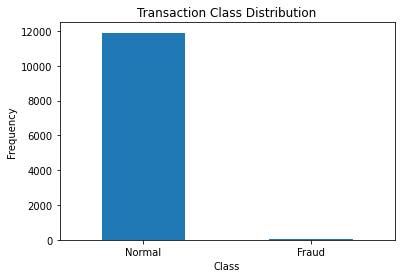

In [5]:
count_classes = pd.value_counts(data['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.title('Transaction Class Distribution')
plt.xticks(range(2),LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [6]:
#Get the fraud and the Normal dataset
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [7]:
print(fraud.shape,normal.shape)

(52, 31) (11906, 31)


In [8]:
#We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count      52.000000
mean       97.724808
std       321.188775
min         0.000000
25%         1.000000
50%         1.000000
75%         1.772500
max      1809.680000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    11906.000000
mean        62.198127
std        177.379105
min          0.000000
25%          5.292500
50%         15.950000
75%         50.000000
max       7712.430000
Name: Amount, dtype: float64

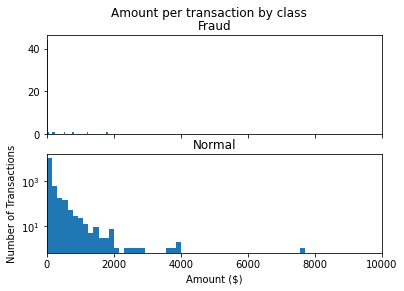

In [10]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(fraud.Amount,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount,bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,10000))
plt.yscale('log')
plt.show()

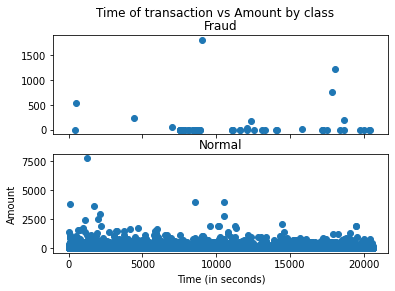

In [11]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time,fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

In [12]:
#Taking samples of the data
data1=data.sample(frac=0.1,random_state=1)
data1.shape

(1196, 31)

In [13]:
data.shape

(11959, 31)

In [14]:
#Determining number of fraud and valid transactions in the dataset
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [15]:
print(outlier_fraction)
print('Fraud Cases : {}'.format(len(Fraud)))
print('Valid Cases : {}'.format(len(Valid)))

0.006734006734006734
Fraud Cases : 8
Valid Cases : 1188


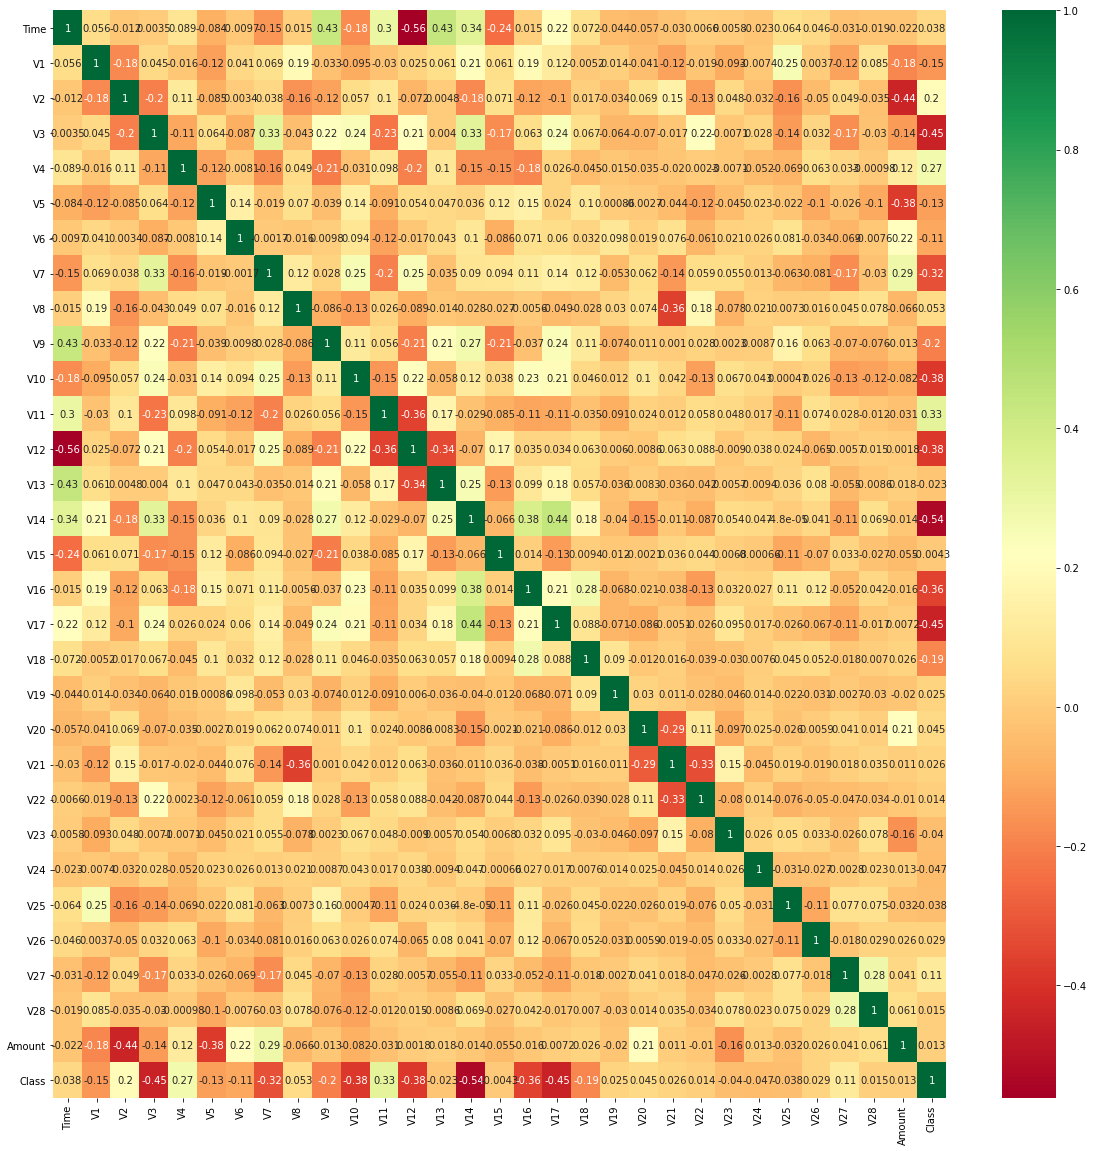

In [16]:
# Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,20))
#plt heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='RdYlGn')

In [17]:
#create independent and dependent features
columns = data1.columns.tolist()
#filter the columns to remove unwanted data
columns = [c for c in columns if c not in ['Class']]
# Store the variable we are predicting
target = 'Class'
#Define a random state
state = np.random.RandomState(42)
X=data1[columns]
Y=data1[target]
X_outliers=state.uniform(low=0,high=1,size=(X.shape[0],X.shape[1]))
print(X.shape)
print(Y.shape)

(1196, 30)
(1196,)


In [18]:
#Defining the outlier detection methods
classifiers = {
    'Isolation Forest':IsolationForest(n_estimators=100,max_samples=len(X),contamination=outlier_fraction,random_state=state,verbose=0),
    'Local Outlier Factor':LocalOutlierFactor(n_neighbors=20,algorithm='auto',leaf_size=30,metric='minkowski'),
    'Support Vector Machine':OneClassSVM(kernel='rbf',degree=3,gamma=0.1,nu=0.05,max_iter=-1)

} 

In [19]:
type(classifiers)

dict

In [20]:
n_outliers=len(Fraud)
for i,(clf_name,clf) in enumerate(classifiers.items()):
  #Fit the data and tag outliers
  if clf_name=='Local Outlier Factor':
    y_pred=clf.fit_predict(X)
    scores_prediction=clf.negative_outlier_factor_
  elif clf_name=='Support Vector Machine':
    clf.fit(X)
    y_pred=clf.predict(X)
  else:
    clf.fit(X)
    scores_prediction=clf.decision_function(X)
    y_pred=clf.predict(X)
  #Reshape the prediction values t0 0 for valid transactions and 1 for fraud transactions
  y_pred[y_pred==1]=0
  y_pred[y_pred==-1]=1
  n_errors=(y_pred!=Y).sum()
  #Classification Metrics
  print('{}: {}'.format(clf_name,n_errors))
  print('Accuracy score :')
  print(accuracy_score(Y,y_pred))
  print('Classification Report :')
  print(classification_report(Y,y_pred))

Isolation Forest: 11
Accuracy score :
0.9908026755852842
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1188
         1.0       0.33      0.38      0.35         8

    accuracy                           0.99      1196
   macro avg       0.66      0.68      0.67      1196
weighted avg       0.99      0.99      0.99      1196

Local Outlier Factor: 148
Accuracy score :
0.8762541806020067
Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      1188
         1.0       0.01      0.12      0.01         8

    accuracy                           0.88      1196
   macro avg       0.50      0.50      0.47      1196
weighted avg       0.99      0.88      0.93      1196

Support Vector Machine: 503
Accuracy score :
0.5794314381270903
Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.58   